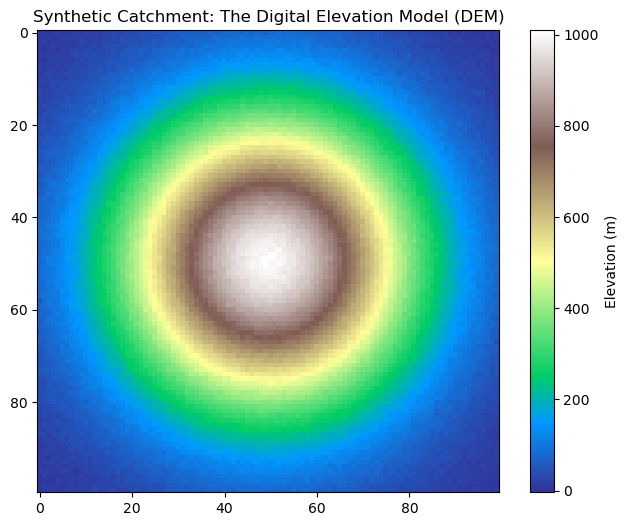

DEM Saved to data/raw/synthetic_dem.tif


In [1]:
# gen synthetic mountain, ai

import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin

# 1. Create a Synthetic Mountain (The Physics of Terrain)
# We use a Gaussian function to make a hill
def create_mountain_dem(shape=(100, 100)): # more shape value = more smooth
    x = np.linspace(-5, 5, shape[0]) # 1d array of 100 coordinates with value in inlcusive and inbetween -5 and 5
    y = np.linspace(-5, 5, shape[1])
    X, Y = np.meshgrid(x, y) #2d array of x and y values

    # A big hill in the middle + some random noise (roughness)
    noise = np.random.normal(0, 5, shape)
    # for x, y = 0, 0 its 1000 since np.exp(0)=1
    Z = 1000 * np.exp(-(X**2 + Y**2)/10)+noise
    # z is the elevation, 0 , 1 are the rows columns like spreadsheet and using x and y values
    return Z

dem_data = create_mountain_dem()

# 2. Visualize the Terrain
plt.figure(figsize=(8, 6))
# imshow -> 2d array in plot, pixel value mapped to a color
plt.imshow(dem_data, cmap='terrain') # a color scheme for high = brown, low = green/blue
plt.colorbar(label='Elevation (m)')
# colorbar maps the elevation data range to colors
plt.title('Synthetic Catchment: The Digital Elevation Model (DEM)')
plt.show()

# 3. Save as a GeoTIFF (The Industry Standard File Format)
# We need to give it a "Location" (Transform) and a "Coordinate System" (CRS)
transform = from_origin(0, 0, 10, 10) # Top-Left at (0,0), Pixel size 10m x 10m
# this can be seen in gis software with base map applied or crs specified


with rasterio.open(
    '../data/raw/synthetic_dem.tif', # file path
    'w', # write mode to create a new file
    driver='GTiff', # specify geotiff standard
    height=dem_data.shape[0], # specifying dimension of a raster
    width=dem_data.shape[1],
    count=1, # no of bands, 1 for single elevation data
    dtype=dem_data.dtype,
    crs='+proj=latlong', # Dummy projection for georeferencing
    transform=transform,
) as dst: # dst is dataset object, context to properly open, write and close the filter
    dst.write(dem_data, 1) # band 1

print("DEM Saved to data/raw/synthetic_dem.tif")


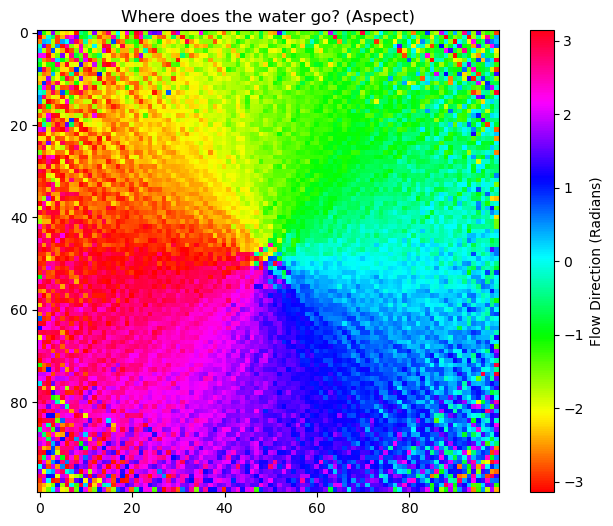

In [2]:
# Calculate Slope (The Steepness)
# The gradient (dz/dx, dz/dy) tells us how fast elevation changes
dz_dy, dz_dx = np.gradient(dem_data, 10, 10)

# Calculate Aspect (The Direction the hill faces)
# Water flows roughly in the direction of steepest descent
# Aspect = arctan(-dx, -dy)

#arctan2 takes two arguments and output = [-pi, pi], arctan takes 1 , [-pi/2, pi/2]
aspect = np.arctan2(-dz_dy, -dz_dx)
# -ve cuz flow vector is negative of gradient vecotr, gradient points uphill, water flows downhill
# positive x axis = east


# Visualize Flow Direction
plt.figure(figsize=(8, 6))
plt.imshow(aspect, cmap='hsv') # HSV is a circular colormap (0 to 360 degrees)
plt.colorbar(label='Flow Direction (Radians)')
plt.title('Where does the water go? (Aspect)')
plt.show()

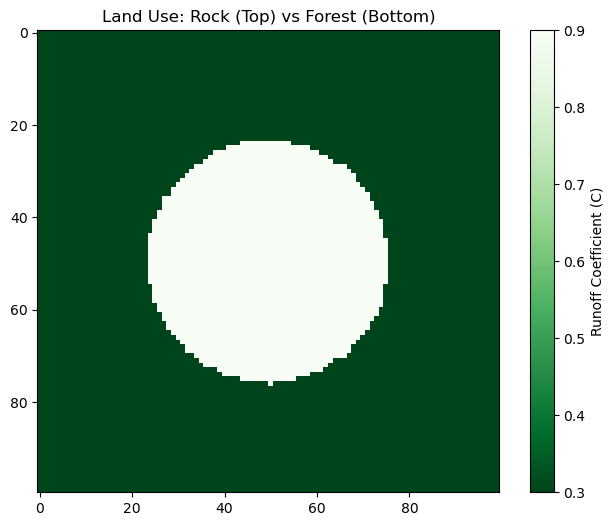

Total Rain Input: 10.00 m3
Total Runoff Generated: 42852.00 m3
Volume Lost to Soil (Infiltration): -42842.00 m3


In [3]:
# 1. Create Land Use Map (C)
# High Elevation (> 500m) = Rock (0.9)
# Low Elevation (< 500m) = Forest (0.3)
runoff_coeff = np.where(dem_data > 500, 0.9, 0.3)

# 2. Visualize Land Use
plt.figure(figsize=(8, 6))
plt.imshow(runoff_coeff, cmap='Greens_r') # Dark Green = Forest
plt.colorbar(label='Runoff Coefficient (C)')
plt.title('Land Use: Rock (Top) vs Forest (Bottom)')
plt.show()

# 3. Calculate Water Yield (Q)
# Rain = 100mm = 0.1 meters
RAIN_DEPTH = 0.1
PIXEL_AREA = 10 * 10 # 100 m2 (from our Transform 10x10)

# Volume per pixel = Area * Rain * C
# Result is in Cubic Meters (m3)
runoff_volume = PIXEL_AREA * RAIN_DEPTH * runoff_coeff

total_volume = np.sum(runoff_volume)

print(f"Total Rain Input: {np.sum(PIXEL_AREA * RAIN_DEPTH):.2f} m3")
print(f"Total Runoff Generated: {total_volume:.2f} m3")
print(f"Volume Lost to Soil (Infiltration): {np.sum(PIXEL_AREA * RAIN_DEPTH) - total_volume:.2f} m3")

In [4]:
#dy  really means dz/dy but the np.grad fxn by default has dy and dx (stepsize) as 1, so we make it 10

slope = np.sqrt(dz_dy**2+dz_dx**2) # sloep is the scalar of gradient
# m = tan theta and we need theta in degree but we get in radians
sl_deg =  np.degrees(np.arctan(slope))

unsafe_pixel_count = np.where(sl_deg>15, 1, 0)

total_area = PIXEL_AREA * dem_data.shape[0]*dem_data.shape[1]
unsafe_area = unsafe_pixel_count.sum()*PIXEL_AREA # each pixel means 100m2

unsafe_area



np.int64(973500)

Max Slope on Road: 73.13 degrees
Avg Slope on Road: 61.77 degrees
VERDICT: ROAD UNSAFE. DO NOT BUILD.


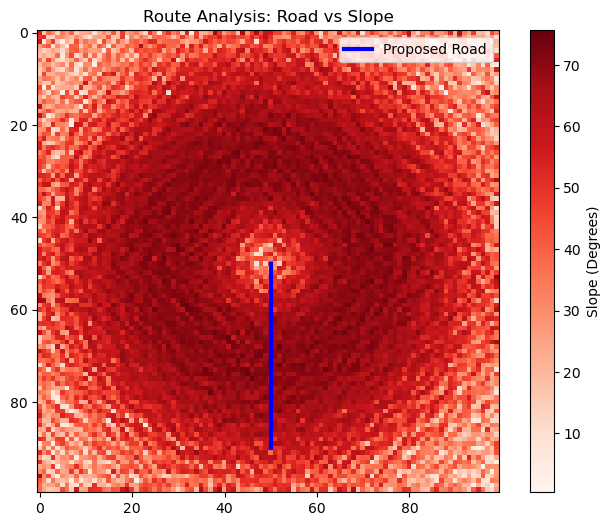

(100, 100)

In [ ]:
import geopandas as gpd
from shapely.geometry import LineString

# 1. Define the Road (Path from bottom-center to center)
# Note: Shapely uses (x, y) = (col, row).
# col = going across diff columns
# Start: Col 50, Row 90 (Bottom). End: Col 50, Row 50 (Peak).
road_geom = LineString([(50, 90), (50, 50)])

# 2. Create GeoDataFrame
# basically df but gdf, adding values to the column
gdf_road = gpd.GeoDataFrame({'id': [1], 'name': ['Access Road']}, geometry=[road_geom])

# 3. Sample the Slope along the Road
# We will iterate through points along the line and check the slope value
# Since we are in pixel-space, we can just interpolate.

length = int(road_geom.length)
# interpolate to gen points at regular intervals, to check at intermeadiate slopes
# for straight line we could for loop but necessary for complex lines
points = [road_geom.interpolate(i) for i in range(length)]

road_slopes = []
for p in points:
    # Get coordinates (Col,`` Row) -> (x, y) -> x normal and y normal vs x matrix and y matrix
    xn, yn = int(p.x), int(p.y)

    # Safety Check: Don't go out of bounds
    if 0 <= yn < dem_data.shape[0] and 0 <= xn < dem_data.shape[1]:
        # Sample the Slope Degree Map you created
        val = sl_deg[yn, xn]
        road_slopes.append(val)

        # eg if point = 50, 90 xn = 50 ..
        # sl_deg[90,50] cuz its numpy array

    # with points we get the location (x,y), then use this to pick slope values located in array
    # sl_deg and append it to road_slopes, as in just pick and place

# 4. The Verdict
max_road_slope = np.max(road_slopes)
mean_road_slope = np.mean(road_slopes)

print(f"Max Slope on Road: {max_road_slope:.2f} degrees")
print(f"Avg Slope on Road: {mean_road_slope:.2f} degrees")

if max_road_slope > 15:
    print("VERDICT: ROAD UNSAFE. DO NOT BUILD.")
else:
    print("VERDICT: ROAD APPROVED.")

# 5. Visual Confirmation
plt.figure(figsize=(8, 6))
plt.imshow(sl_deg, cmap='Reds') # Background is Slope
plt.colorbar(label='Slope (Degrees)')

# Plot the road
xn, yn = road_geom.xy
plt.plot(xn, yn, color='blue', linewidth=3, label='Proposed Road')

plt.title('Route Analysis: Road vs Slope')
plt.legend()
plt.show()